# Debiasing word embeddings

Word embeddings are high-dimensional vectors, typically denoted as $\vec{w} \in \mathbb{R}^d$, where $d$ signifies the dimensionality of the embedding space. These vectors are meticulously crafted to encode semantic relationships among words in natural language by positioning semantically similar words closer to each other within the embedding space. Each dimension of the vector corresponds to a distinct semantic aspect or feature of the word's meaning or usage.

However, a critical challenge persists: traditional GloVe embeddings tend to cluster words based on contextual similarity, potentially adding bias based on corpus of text it was trained on. The issue of gender bias arises when the vector representation of a word, presumed to be gender-neutral (e.g., $\overrightarrow{\text{business}}$, $\overrightarrow{\text{sport}}$), exhibits closer proximity to one gender-defining word (e.g., $\overrightarrow{\text{male}}$) than to another (e.g., $\overrightarrow{\text{female}}$) within the embedding space. This phenomenon can reflect and perpetuate societal biases and imbalances, highlighting the importance of ensuring fairness and neutrality in word embeddings.


In [1]:
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import random

### Model download

We use Microsoft Pri-2 model - transformer with $2.7$ billion parameters.

You can download it [here](https://huggingface.co/microsoft/phi-2).

Phi-2 is a Transformer-based model with a next-word prediction objective, trained on 1.4T tokens from multiple passes on a mixture of Synthetic and Web datasets for NLP and coding. The training for Phi-2 took 14 days on 96 A100 GPUs.

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Indicating the bias

To measure the similarity between two words represented by their embeddings, we are going to use cosine similarity.

Firstly, we define the list of words that are aimed to be gender-neutral.

In [4]:
gender_neutral_words = []

with open("neutral_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_neutral_words.append(word.strip())

gender_neutral_words[:10]

['brain',
 'super',
 'mathematics',
 'IT',
 'master',
 'chemistry',
 'dancing',
 'dance',
 'dancer',
 'athlete']

Secondly, we want to be able to tokenize the words (meaning representing a word as a high-dimensional vector). The following function return embeddings of word. If word is encoded with multiple tokens than only encoding of first token will be returned. Firstly we will only limit with words that are encoded with single token, but further we will extend this idea to more general case, allowing multiple tokens.

In [5]:
def get_embeddings(word: str):
  '''
  Get vector embedding of a specific word.
  '''
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokens = tokenizer(word, return_tensors="pt", padding = True, return_attention_mask=False)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  tokens_current.shape
  return tokens_current[0][0]

For example:

In [6]:
print(get_embeddings("dog"))

tensor([-0.0034,  0.0041,  0.0026,  ...,  0.0219, -0.0308, -0.0073],
       dtype=torch.float16)


In [7]:
outputs = model(torch.tensor([[50000]]))
tokens_current = outputs.hidden_states[0].cpu()
print(tokens_current)

tensor([[[ 0.0213,  0.0339, -0.0301,  ...,  0.0028, -0.0131, -0.0156]]],
       dtype=torch.float16, grad_fn=<ToCopyBackward0>)


Cosine similarity computes the cosine of the angle between the vectors of the two words in the embedding space. The formula for the cosine between two vectors is defined as:

$$ \cos(\vec{u}, \vec{v}) = \frac{ \langle \vec{u}, \vec{v} ⟩}{\lVert \vec{u} \rVert \lVert \vec{v} \rVert}, $$

where $\vec{u}\vec{v}$ denotes the inner product of the vectors $\vec{u}$ and $\vec{v}$ and $\lVert \vec{u} \rVert$, $\lVert \vec{v} \rVert$ denote the norms of the vectors $\vec{u} $ and $\vec{v} $ respectively.

It quantifies the similarity in direction between the vectors, with a value close to $1$ indicating high similarity and a value close to $-1$ indicating dissimilarity. However, it does not capture the magnitudes of the vectors.  In the context of ensuring fairness or lack of bias, we aim for equal cosine similarities between a given word and two gender-specific terms, typically male and female. For instance, if we consider the word 'business' as gender-neutral, then the cosine similarity between $\overrightarrow{business}$ and $\overrightarrow{male}$ should ideally be equal to the cosine similarity between $\overrightarrow{business}$ and $\overrightarrow{female}$, or at least very close to each other. This ensures that the representation of the word 'business' in the embedding space exhibits neutrality with respect to gender associations.

As a metrics of the biasness we chose the absolute difference between the cosine similarities of the word and two gender-specific words. For instance, for word $\vec{w}$:

$$\mbox{difference} = |cos(\overrightarrow{w}, \overrightarrow{\mbox{he}}) - cos(\overrightarrow{w}, \overrightarrow{\mbox{she}})|$$
The smaller is this difference, the less bias the particular word has.

It is important to note that there is no ideal way to describe biasness. Cosine similarity is just one of the metrics that is usually used.

In [8]:
def cosine_similarity(u, v):
  '''
  Calculates the cosine similarity bettwen two vectors.
  It is the inner product of two vectors divided by product of their norms.
  '''
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def calculate_gender_bias(neutral_word, male_gender, female_gender):
  '''
  Calculates the bias. If the sign is positive - the word is biased in male direction; if negative - in female direction.
  '''
  return cosine_similarity(neutral_word, male_gender) - cosine_similarity(neutral_word, female_gender)

def calculate_difference(neutral_word, male_gender, female_gender):
  '''
  Calculates the absolute difference between cosine similarities of two vectors with other.
  '''
  return abs(calculate_gender_bias(neutral_word, male_gender, female_gender))

### Define gender-specific words

To define the gender-specific subspace $G$ we need to define the pairs of gender-specific words:

In [9]:
gender_words_female = []
gender_words_male = []

with open("female_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_words_female.append(word.strip())

with open("male_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_words_male.append(word.strip())

tokens_list = []
tokenizer.pad_token = tokenizer.eos_token
for index, pair in enumerate(zip(gender_words_female, gender_words_male)):
  embeddings = []
  tokens = tokenizer(pair, return_tensors="pt", padding = True, return_attention_mask=False)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  if tokens_current.shape == torch.Size([2, 1, 2560]):
    tokens_list.append(pair)

Then, we choose only words that are represented by a single token.

In [10]:
tokens = tokenizer("mr", return_tensors="pt", padding = True, return_attention_mask=False)
with torch.no_grad():
    outputs = model(**tokens)
tokens_current = outputs.hidden_states[0].cpu()

In [11]:
set(tokens_list)

{('aunt', 'uncle'),
 ('daughter', 'son'),
 ('female', 'male'),
 ('girl', 'boy'),
 ('her', 'his'),
 ('lass', 'lad'),
 ('miss', 'mr'),
 ('mom', 'dad'),
 ('mother', 'father'),
 ('she', 'he'),
 ('wife', 'husband'),
 ('woman', 'man'),
 ('women', 'men')}

As we can see, we defined the $13$ pairs of gender-specific words.

### Form differences of gender-specific words

So we need to form the vectors as differences of the above vectors, because the differences define the gender subset.

In [12]:
words = list(set(tokens_list))

difference_vectors = []
for word_female, word_male in words:
  differece = get_embeddings(word_female) - get_embeddings(word_male)
  difference_vectors.append(differece)


difference_vectors = np.array(difference_vectors)
difference_vectors = difference_vectors.astype(np.float32)

Now we have $13$ vectors that define the gender subset $G$.

### Dimensionality reduction

In order to word with less than $13$ vectors that define $G$, we use the principal component analysis to find the $k$ most significant vectors. Also, this vectors will be orthogonal. This is needed to capture more generalized difference between genders.

PCA analyzes the variance of the data in its original basis and aims  identify the directions in which the variance is maximal. Subsequently, PCA utilizes first $k$ significant directions to define the new basis.

Let difference vectors be $v_1, ..., v_n$.

To perform PCA, we need to construct a matrix taking vectors $v_1, ..., v_n$ as rows:

$$X = \begin{bmatrix}
    v_{1}\\
    v_{2}\\
    \cdots\\
    v_{13}  
 \end{bmatrix}$$


 Then, we need to center the matrix $X$ by subtracting its mean from it:

$$X_{i, j} = X_{i, j} - \bar{X_j},$$

 where $X_{i, j}$ denotes the $(i, j)$-th element of $X$ and $\bar{X_j}$ denotes the mean value of the variable $X_j$.

Now we need to construct the covariance matrix of matrix $X$, which is defined as


$$C = \begin{bmatrix}
    \mbox{Var}(X_1) & \mbox{Cov}(X_1, X_2) & ... & \mbox{Cov}(X_1, X_n) \\
    \mbox{Cov}(X_2, X_1) & \mbox{Var}(X_2) & ... & \mbox{Cov}(X_1, X_n) \\
    \cdots & \cdots & \cdots & \cdots\\
    \mbox{Cov}(X_n, X_1) & \mbox{Cov}(X_n, X_2) & ... & \mbox{Var}(X_n)
 \end{bmatrix}$$
In our case:
 $$C = XX^T = \begin{bmatrix}
    v_1v_1^T & v_1v_2^T & ... & v_1v_n^T \\
    v_2v_1^T & v_2v_2^T & ... & v_2v_n^T \\
    \cdots & \cdots & \cdots & \cdots\\
    v_nv_1^T & v_nv_2^T & ... & v_nv_n^T
 \end{bmatrix}$$

Note that this matrix is symmetric since $\mbox{Cov}(X_i, X_ j) = \mbox{Cov}(X_j, X_i)$.

Next, we proceed to find the eigenvalues and eigenvectors of the matrix $C$.
Suppose the $\lambda_1, \lambda_2, ..., \lambda_n$ are eigenvalues of the matrix $C$, sorted in the descending order. Then the first $k$ eigenvectors are considered to be principal eigenvectors and the $\frac{\lambda_i}{\sum{\lambda_j}}$ is the proportion of variance explained by the $i$-th eigenvector.


In [13]:
n, p =  2560, 13
X = difference_vectors.T
X -= np.mean(X, axis=0)

C = np.cov(X, rowvar=False)
l, principal_axes = la.eig(C)

idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
principal_components = X.dot(principal_axes)

Now, our task is to determine the appropriate value for $k$. One common method used for this purpose is the Elbow method. It aims to plot the cumulative explained variance agains the number of components.

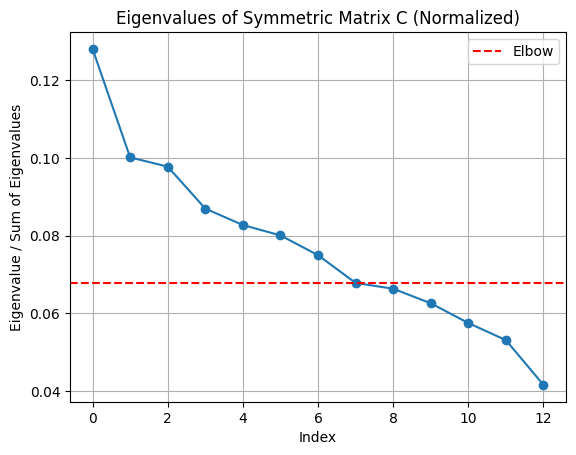

In [14]:
eigenvalues, eigenvectors = la.eigh(C)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

eigenvalue_sum = np.sum(sorted_eigenvalues)

normalized_eigenvalues = sorted_eigenvalues / eigenvalue_sum

plt.plot(normalized_eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue / Sum of Eigenvalues')
plt.title('Eigenvalues of Symmetric Matrix C (Normalized)')
plt.grid(True)

plt.axhline(y=normalized_eigenvalues[7], color='r', linestyle='--', label='Elbow')

plt.legend()
plt.show()


Once $k$ reaches 7, it becomes apparent from the graph that additional reductions do not result in a significant decrease. Therefore, we have opted for $k=7$ and have extracted the first 7 eigenvectors for further analysis to serve as the basis vectors for the space $G$. These eigenvectors are denoted as $g_1, ..., g_7$. Being eigenvectors of a symmetric matrix, they are pairwise orthogonal.

In [15]:
k = 7
PCA_k = principal_components[:, 0:k]

### Soft debiasing

To neutralize the bias component of a given word vector $\vec{w}$, we aim to project this vector onto the gender-neutral subspace $N$. Given that $N + G = \mathbb{R}^d$, the spaces $G$ and $N$ are orthogonal. Consequently, every vector $\vec{w} \in \mathbb{R}^d$ can be decomposed as:

$$\vec{w} = \vec{w_{G}} + \vec{w_{N}},$$

where $\vec{w_{N}}$ represents the projection of $\vec{w}$ onto the affine space $N$, and $\vec{w_{G}}$ signifies the projection onto $G$.

Therefore,
$$\vec{w_{N}} = \vec{w} - \vec{w_{G}}$$

Given that the basis vectors of $G$ are orthogonal, we can obtain $\vec{w_{G}}$ as the sum of the projections onto these basis vectors:

$$\vec{w_{G}} = \sum_{i=1}^{7}{\vec{w_{g_i}}}$$
where $\vec{w_{g_i}}$ denotes the projection of $\vec{w}$ onto the basis vector $g_i$.
The projection matrix onto the linear span of $g_i$ is defined as:

$$P_{g_i} = \frac{g_ig_i^T}{g_i^Tg_i}$$

So the overall projection is calculated as follows:

$$\vec{w_{G}} = \sum_{i=1}^{7}{P_{g_i}g_i} = \sum_{i=1}^{7}{\frac{g_ig_i^T}{g_i^Tg_i}g_i}$$

Here we find projectors for each vector.

In [16]:
projectors = []
for i in range(PCA_k.shape[-1]):
  a = PCA_k[:, i]
  projectors.append(np.outer(a, a) / np.inner(a, a))

### Example of debiasing

The debiased vector looks as follows:

$$\vec{w_{N}} = \vec{w} - \sum_{i=1}^{7}{P_{g_i}g_i} = \vec{w} - \sum_{i=1}^{7}{\frac{g_ig_i^T}{g_i^Tg_i}g_i}$$

In [17]:
def debias_word(word):
  '''
  Debiasing the word by taking projection.
  '''
  projection = projectors[0] @ word
  for i in range(1, 7):
    projection += projectors[i] @ word
  return word - projection

In [18]:
football = get_embeddings("good").numpy()

male = get_embeddings(words[2][0]).numpy()
female = get_embeddings(words[2][1]).numpy()

In [19]:
unbiased = debias_word(football)

Cosine similarities before the debias:

In [20]:
print(cosine_similarity(football, male))
print(cosine_similarity(football, female))

0.0349
0.02026


Cosine similarities after the debias:

In [21]:
print(cosine_similarity(unbiased, male))
print(cosine_similarity(unbiased, female))

0.027621534900788815
0.02322177593323389


In [22]:
print('Difference before:', calculate_difference(football, male, female))
print('Difference after:', calculate_difference(unbiased, male, female))

Difference before: 0.01465
Difference after: 0.004399758967554925


As we can see difference between cosine similarity greatly reduced.

### Debiasing list of words

Now we will debias list of biased words.

In [23]:
cosine_similarities = []

for word_neutral in gender_neutral_words:
  embedding = get_embeddings(word_neutral)
  cosine_similarities.append((word_neutral, calculate_difference(embedding, male, female)))

sorted_cosine_similarities = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)

print(sorted_cosine_similarities[:20])

[('passenger', 0.09955), ('county', 0.09814), ('recipient', 0.0914), ('learner', 0.087), ('advocate', 0.08514), ('era', 0.08307), ('era', 0.08307), ('fraternity', 0.08093), ('lender', 0.08026), ('occupant', 0.0786), ('occupier', 0.0786), ('occupant', 0.0786), ('occupier', 0.0786), ('operator', 0.07385), ('dancing', 0.0736), ('dance', 0.0736), ('dancer', 0.0736), ('dweller', 0.0736), ('dweller', 0.0736), ('doodad', 0.0736)]


In [24]:
len(gender_neutral_words)

429

In [25]:
differences_before = []
differences_after = []
unbiased_list = []
he = get_embeddings('he').numpy()
she = get_embeddings('she').numpy()

def soft_debias(word):
  word = get_embeddings(word).numpy()
  differences_before.append(calculate_difference(word, he, she))
  projection = (projectors[0] @ word + projectors[1] @ word+ projectors[2] @ word +
          projectors[3] @ word+ projectors[4] @ word +
          projectors[5] @ word+ projectors[6] @ word)
  unbiased = word - projection

  return unbiased

for word in gender_neutral_words[:50]:

  debiased = soft_debias(word)
  unbiased_list.append(debiased)
  differences_after.append(calculate_difference(debiased, he, she))

print("Before:", differences_before)
print("After:", differences_after)

Before: [0.0394, 0.02985, 0.02005, 0.163, 0.02419, 0.02621, 0.1254, 0.1254, 0.1254, 0.0939, 0.0010605, 0.0084, 0.04654, 0.0206, 0.0626, 0.0372, 0.008965, 0.013245, 0.01236, 0.02142, 0.1404, 0.00598, 0.06683, 0.01352, 0.05386, 0.00454, 0.01822, 0.05295, 0.10345, 0.04004, 0.02376, 0.1562, 0.00763, 0.169, 0.03833, 0.0265, 0.02933, 0.0435, 0.0204, 0.002075, 0.00899, 0.03284, 0.04327, 0.04575, 0.02055, 0.1506, 0.1045, 0.01439, 0.04092, 0.02856]
After: [0.006627842734166271, 0.006931869223732939, 0.003318229461766343, 0.007552872863473559, 0.005682225962539185, 0.006051123121759375, 0.009082224916057993, 0.009082224916057993, 0.009082224916057993, 0.0061833367504733686, 4.799080588267779e-05, 0.004190502771110266, 0.007604939096489856, 0.007583923057516496, 0.006967585096121359, 0.006469283159354509, 0.002911367314238203, 0.010366411262282112, 0.005365074173747677, 0.011596515765215872, 0.013250024039405728, 0.0035378765905013272, 0.008255401717643093, 0.002300409441365154, 0.001225285274776

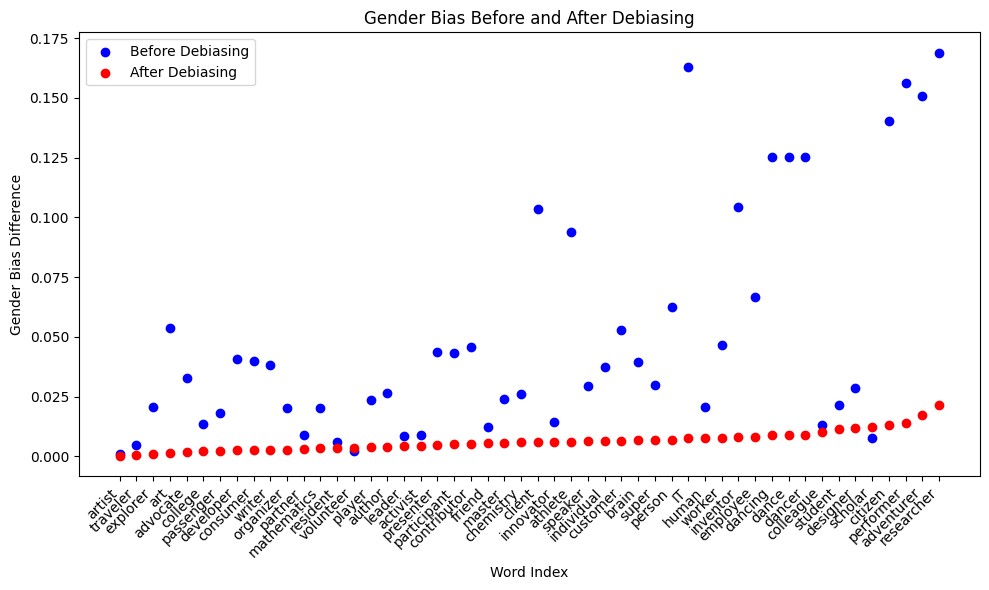

In [26]:
words_and_diffs = list(zip(gender_neutral_words, differences_before, differences_after))
sorted_words_and_diffs = sorted(words_and_diffs, key=lambda x: x[2])

gender_neutral_words_sorted, differences_before_sorted, differences_after_sorted = zip(*sorted_words_and_diffs)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(gender_neutral_words_sorted)), differences_before_sorted, label='Before Debiasing', color='blue')
plt.scatter(range(len(gender_neutral_words_sorted)), differences_after_sorted, label='After Debiasing', color='red')
plt.xlabel('Word Index')
plt.ylabel('Gender Bias Difference')
plt.title('Gender Bias Before and After Debiasing')
plt.legend()
plt.xticks(range(len(gender_neutral_words_sorted)), gender_neutral_words_sorted, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Hard debiasing

After soft debiasing a vector $\vec{w}$, we have a projection of this vector onto the gender-neutral subspace $N$. That mean that the the projection of this vector onto gender space is $0$. We have removed bias from word itself, but there is one more step to make it better. Our gender defining words not necessarily are equally distant. In order to make that a case, we use equalization that will make our gender defining words equally distant to all words $\vec{w_{N}}$. We don't have to recalculate distance for every word, as in subspace $N^\perp$  our vectors 0.
$$\mu := \frac{\sum_{w \in E} W}{E}$$
Where $\mu$ is average of the equalization set $E$.
In this formula we take average of every equalization set (in our case pair).
$$v := \mu - \mu_B $$
Where $\mu_B$ is projection of $\mu$ onto gender defining subspace.
Then for every $\vec{w}$
$$\vec{w} := \nu + \sqrt{1 - ||\nu||^2} \frac{\vec{w}_B - \mu_B}{||\vec{w}_B - \mu_B||}$$
Where $\vec{w}_B$ projection on gender defining subspaces.
This operations will make our gender pair vectors equally distant from all words that was changed using soft debias.

In [27]:
gender_defining = []

def hard_debias(pair):

  embeddings = get_embeddings(pair[0]).numpy(), get_embeddings(pair[1]).numpy()
  mean = np.mean(embeddings, axis=0)
  v = mean - (projectors[0] @ mean + projectors[1] @ mean)
  v = v / np.linalg.norm(v)
  proj_1 = projectors[0] @ embeddings[0] + projectors[1] @ embeddings[0] - (projectors[0] @ mean + projectors[1] @ mean)
  proj_2 = projectors[0] @ embeddings[1] + projectors[1] @ embeddings[1] - (projectors[0] @ mean + projectors[1] @ mean)
  w_1 = v + (np.sqrt(1 - (np.linalg.norm(v))**2) * proj_1) / np.linalg.norm(proj_1)
  w_2 = v + (np.sqrt(1 - (np.linalg.norm(v))**2) * proj_1) / np.linalg.norm(proj_1)
  return (w_1, w_2)
for pair in words:
  debiased = hard_debias(pair)
  gender_defining.append(debiased)


In [28]:
differences_after_new = []


he = gender_defining[2][0]
she = gender_defining[2][1]

for word_unbiased in unbiased_list:
  differences_after_new.append(calculate_difference(word_unbiased, he, she))

print("After:", differences_after_new)

After: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


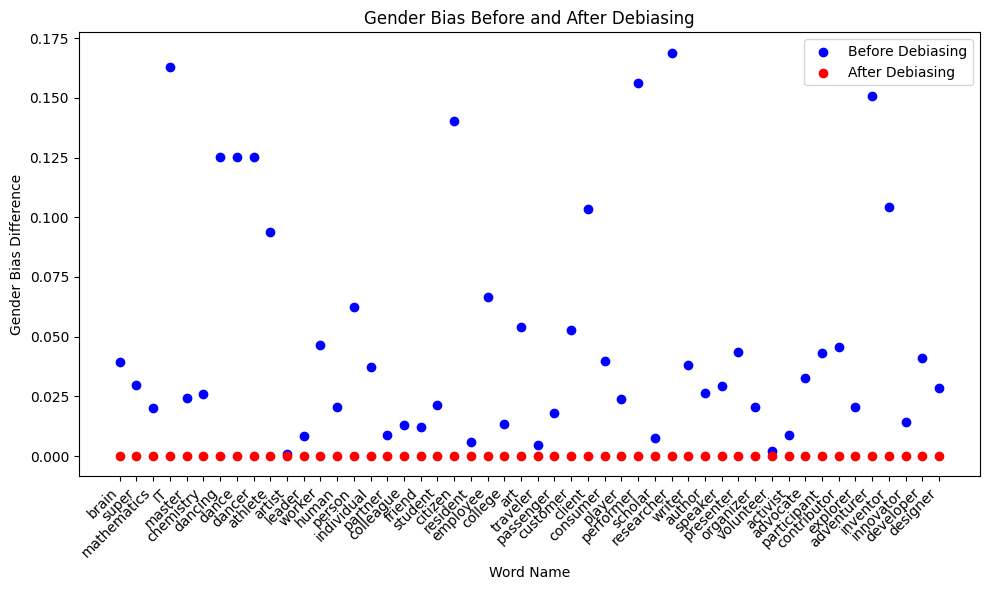

In [29]:
words_and_diffs = list(zip(gender_neutral_words, differences_before, differences_after_new))
sorted_words_and_diffs = sorted(words_and_diffs, key=lambda x: x[2])

gender_neutral_words_sorted, differences_before_sorted, differences_after_sorted = zip(*sorted_words_and_diffs)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(gender_neutral_words_sorted)), differences_before_sorted, label='Before Debiasing', color='blue')
plt.scatter(range(len(gender_neutral_words_sorted)), differences_after_sorted, label='After Debiasing', color='red')
plt.xlabel('Word Name')
plt.ylabel('Gender Bias Difference')
plt.title('Gender Bias Before and After Debiasing')
plt.legend()
plt.xticks(range(len(gender_neutral_words_sorted)), gender_neutral_words_sorted, rotation=45, ha='right')
plt.tight_layout()
plt.show()

As we can see difference between cosine similarities now is totally zero.

### WEAT test

WEAT, presents a robust evaluation framework to measure the extent to which a model links sets of target words, such as ``business``, ``football``, ``science``, etc., with two distinct sets of attribute words, typically related to gender, such as ``male`` and ``female``.

Central to the WEAT test are two key hypotheses:

Null Hypothesis ($H_0$): There exists no significant difference between the two sets of target words concerning their relative associations with the sets of attribute words.

Alternative Hypothesis ($H_1$): There exists a difference between the two sets of target words.

The test statistic is computed by normalizing the mean difference between the associations of the target sets with the attribute sets. This statistic provides a quantified measure of the separation between the distributions of associations.

In [465]:
X = ["bad", "work", "rich", "football", "wise"]
Y = ["leader", "good", "home", "poor", "smart"]
A = ['he', "male", "man"]
B = ['she', "female", "woman"]

In [466]:
def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two vectors.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2 + 0.00001)
    return similarity

In [467]:
def mean_cos_similarity(word_embedding, A_embeddings, B_embeddings):
    """
    Compute mean cosine similarity between word embedding and the mean of attribute word embeddings A and B.

    Args:
        word_embedding (numpy.ndarray): The embedding vector for the target word.
        A_embeddings (numpy.ndarray): Array containing embedding vectors for words in set A.
        B_embeddings (numpy.ndarray): Array containing embedding vectors for words in set B.

    Returns:
        float: The difference of mean cosine similarities.
    """
    mean_A = np.mean(A_embeddings, axis=0)
    mean_B = np.mean(B_embeddings, axis=0)

    cos_sim_A = cosine_similarity(word_embedding, mean_A)
    cos_sim_B = cosine_similarity(word_embedding, mean_B)

    return cos_sim_A - cos_sim_B

In [468]:
def weat_effect_size(X, Y, A, B):
    X_embed = np.array(X)
    Y_embed = np.array(Y)
    A_embed = np.array(A)
    B_embed = np.array(B)

    mean_X = np.mean([mean_cos_similarity(x, A_embed, B_embed) for x in X_embed])
    mean_Y = np.mean([mean_cos_similarity(y, A_embed, B_embed) for y in Y_embed])

    combined_embeddings = np.concatenate((X_embed, Y_embed))
    std_dev = np.std([mean_cos_similarity(w, A_embed, B_embed) for w in combined_embeddings])

    effect_size = (mean_X - mean_Y)

    return effect_size

In [469]:
from itertools import combinations

def generate_pairs(X, Y):
    min_size = min(len(X), len(Y))
    X_Y = X + Y
    partition_size = len(X_Y) // 2
    for c in combinations(X_Y, partition_size):
      c2 = set(X_Y) - set(c)
      yield c, c2

In [470]:
def permutation_test(X, Y, A, B):

    num_X = len(X)
    num_Y = len(Y)
    num_samples = num_X + num_Y
    permuted_effect_sizes = []
    original_effect_size = weat_effect_size(X, Y, A, B)
    for pair in generate_pairs(X, Y):
        numpy_array_pair_1 = np.stack([tensor.numpy() for tensor in pair[0]])
        numpy_array_pair_2 = np.stack([tensor.numpy() for tensor in pair[1]])
        permuted_effect_sizes.append(weat_effect_size(numpy_array_pair_1, numpy_array_pair_2, A, B))
    p_value = np.mean(np.array(permuted_effect_sizes) >= original_effect_size)
    return p_value


In [471]:
X_def = list(map(get_embeddings, X))
Y_def = list(map(get_embeddings, Y))
A_def = list(map(get_embeddings, A))
B_def = list(map(get_embeddings, B))


### Without debiasing results

In [472]:
permutation_test(X_def, Y_def, A_def, B_def)

0.015873015873015872

### Soft Debias results


In [473]:

X_soft = []
Y_soft = []
for word in X:
  X_soft.append(soft_debias(word))

for word in Y:
  Y_soft.append(soft_debias(word))


In [474]:
tensor_X_soft = [torch.tensor(row.tolist(), dtype=torch.float32, device = "cpu") for row in X_soft]
tensor_Y_soft = [torch.tensor(row.tolist(), dtype=torch.float32, device = "cpu") for row in Y_soft]
permutation_test(tensor_X_soft, tensor_Y_soft, A_def, B_def)

0.7857142857142857

### Hard Debias results


In [475]:
A_hard, B_hard = [], []

for element in np.array(list(zip(A, B))):
  result = hard_debias(element)
  A_hard.append(result[0])
  B_hard.append(result[1])

In [476]:
permutation_test(tensor_X_soft, tensor_Y_soft, A_hard, B_hard)

1.0


**Without debiasing**: The obtained $p$-value of $0.015$ leads to the rejection of the null hypothesis. Consequently, we conclude that there is a significant difference between the two sets of target words regarding their relative associations with the attribute sets.\
**Soft debiasing**: The $p$-value of $0.78$ does not provide sufficient evidence to reject the null hypothesis. Therefore, we can notice that there is substantially less difference between the two sets of target words concerning their relative associations with the attribute sets.\
**Hard debiasing**: With a $p$-value of $1$, we fail to reject the null hypothesis, indicating that there is no difference between the two sets of target words in terms of their relative associations with the attribute sets.


### Updating embeddings

Now after creating all necessary functions it is reasonable to try this in action on real world embeddings of phi-2 model.

Let's get answer of model on prompt "Women are better than men in".

In [477]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in terms, especially, emotional intelligence. Women tend towards empathy, compassion, understanding, patience, tolerance, forgiveness, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend

We can see that model try to prove given statement. It uses such adjactives like compassionate and empathetic to do that. Also rest of text are aimed to promote womens leadership.

We can't say that this answer is totaly bised and wrong, but it definitely could be better.

Now let's soft debias adjactives model used for response, for example: empathetic, compassionate and few more that can be used for potential answer.

In [478]:
words_to_zero = ["nurturing","empathetic","compassionate","math","science","beautiful","intelligent","creative"]
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in words_to_zero:
    for token in tokenizer.tokenize(i.lower()):
        model_embeddings.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
        model_embeddings_out.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

And now let's rerun our prompt.

In [479]:
inputs = tokenizer(
  '''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in terms, especially, emotional intelligence. Women tend towards empathy, compassion, understanding, patience, tolerance, forgiveness, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend towards nurturing, caring, loving, etc. These qualities, along, emotional intelligence, makes woman, especially, mothers, perfect caregivers. Women, especially, mothers, tend

At first it seems that it did't become better. But if we read all response to the end we notice that model also started to promote men. Also model concluded that "Both men and women have their strengths and weaknesses, and it is up to each individual to find their own path in life."

To conlude we didn't got absolutely debiased results, as a big part of bias is hidden inside the model. But that is definitely step in correct direction.

Also it was interesting for us to try debias big number of tokens that and look on results. In next tests we debiased 10000 tokens out of 50000 available in current model.

In [ ]:
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in range(100,10000):
    print(i)
    outputs = model(torch.tensor([[i]]))
    tokens_current = outputs.hidden_states[0].cpu()
    word = tokens_current[0][0].detach().numpy()
    projection = (projectors[0] @ word + projectors[1] @ word+ projectors[2] @ word +
          projectors[3] @ word+ projectors[4] @ word +
          projectors[5] @ word+ projectors[6] @ word)
    unbiased = word - projection
    model_embeddings.weight.data[i] = torch.tensor(unbiased)
    model_embeddings_out.weight.data[i] = torch.tensor(unbiased)
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

Now if we try to give the previous prompt we get quite interesting results. Now model don't distinguish between women and men, and starts to list all known adjectives to prove initial statement.

In [481]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in math, physics, chemistry, biology, psychology, economics, sociology, anthropology, linguistically, geography, archeologically, ethnologically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, 

If we change our prompt to "Men are better than women in" we can see almost no difference in response that proves that our words it totally unbiased.

In [482]:
inputs = tokenizer('''Men are better than women in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Men are better than women in math, physics, chemistry, biology, economics, psychology, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, an

In conclusion: we can see that answers before and after debiase is changed in correct direction. However debias problem requires more complex approach as words embedding is only a part of problem.

#K-means clustering

K-means, a widely used unsupervised clustering algorithm in machine learning and data mining, endeavors to segment a dataset into k clusters, where each data point is assigned with the cluster whose centroid is closest to it in terms of Euclidean Distance.

Here we do not use K-means for clustering, as we use it on labeled dataset. It is just another metric to define how separated 2 classes are.

Here if word is encoded with multiple tokens we will take average of them.

In [483]:
male = ["rich", "bad", "football", "technician", "developer", "cool", "mechanic", "sport", "driver", "strong","Pilot", "Lawyer", "Scientist", "Entrepreneur", "Professor", "Doctor"]
female = ["good", "poor", "artist", "teacher", "designer", "singer", "weak", "business", "smart", "Nurse", "Chef", "Writer", "Librarian", "Social Worker"]


In [484]:
def get_embeddings_all(word: str):
  '''
  Get vector embedding of a specific word.
  '''
  tokens = tokenizer(word, return_tensors="pt", padding = True, return_attention_mask=False)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  tokens_current.shape
  return np.array(tokens_current[0])

In [485]:

def soft_debias_all(word):
  words = get_embeddings_all(word)
  result = []
  for token in words:
    projection = (projectors[0] @ token + projectors[1] @ token+ projectors[2] @ token +
            projectors[3] @ token+ projectors[4] @ token +
            projectors[5] @ token+ projectors[6] @ token)
    unbiased = token - projection
    result.append(unbiased)
  return np.array(result)

In [486]:
model_embeddings = model.get_input_embeddings()
female_debiased_all = []
male_debiased_all = []

female_default = []
male_default = []

for index,value in enumerate(male):
    for token in tokenizer.tokenize(value.lower()):
        male_default.append(np.mean(get_embeddings_all(token), axis = 0))
        male_debiased_all.append(np.mean(soft_debias_all(token), axis = 0))

for index,value in enumerate(female):
    for token in tokenizer.tokenize(value.lower()):
        female_default.append(np.mean(get_embeddings_all(token), axis = 0))
        female_debiased_all.append(np.mean(soft_debias_all(token), axis = 0))

### Results before debiasing

In [487]:
np.random.seed(21)

result = np.concatenate((np.array(female_default), np.array(male_default)))

labels_female = np.zeros(len(female_default))
labels_male = np.ones(len(male_default))
all_labels = np.concatenate((labels_female, labels_male))

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=3000)
kmeans.fit(result)


predicted_labels = kmeans.labels_

accuracy = accuracy_score(all_labels, predicted_labels)
accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5208333333333334

### Results after debiasing

In [488]:
result = np.concatenate((np.array(female_debiased_all), np.array(male_debiased_all)))

labels_female = np.zeros(len(female_debiased_all))
labels_male = np.ones(len(male_debiased_all))
all_labels = np.concatenate((labels_female, labels_male))

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=3000)
kmeans.fit(result)


predicted_labels = kmeans.labels_

accuracy = accuracy_score(all_labels, predicted_labels)
accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4375

Despite our efforts, biased words still tend to cluster together, as revealed by K-means clustering analysis on a curated list of words, documented on our GitHub. Prior to debiasing, the algorithm achieved a 52\% accuracy rate in clustering male and female biased words, which slightly dropped to 44\% post-debiasing. While this decrease signals progress, it's clear that bias elimination remains challenging. Our classification accuracy percentages are not that big due to the nature of ELMO embeddings, which capture context where it is used. These findings underscore the complexity of debiasing language models.

On Word2Vec Ebeddings authors of paper "Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them
" got following results:
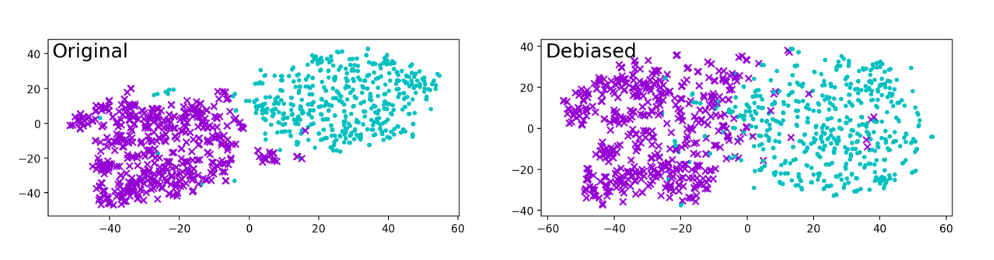

Where accuracy reduced from 99% to 92%, indicating that cosine similarity is not perfect way to measure bias.

# Conclusion
In conclusion, this research project delves into the critical issue of bias within word embeddings, particularly in the context of Large Language Models (LLMs). We investigated that linear algebra techniques produce great results in debiasing the embeddings.

Addressing bias in large language models (LLMs) is a complex challenge. While adjusting embeddings is one aspect, bias can hide throughout various layers. Even minor alterations to the meaning of a word can have serious consequences, especially in critical fields like medicine. Therefore, it's crucial to approach bias mitigation on a case-by-case basis, considering the specific context and potential impacts.



